# Topology

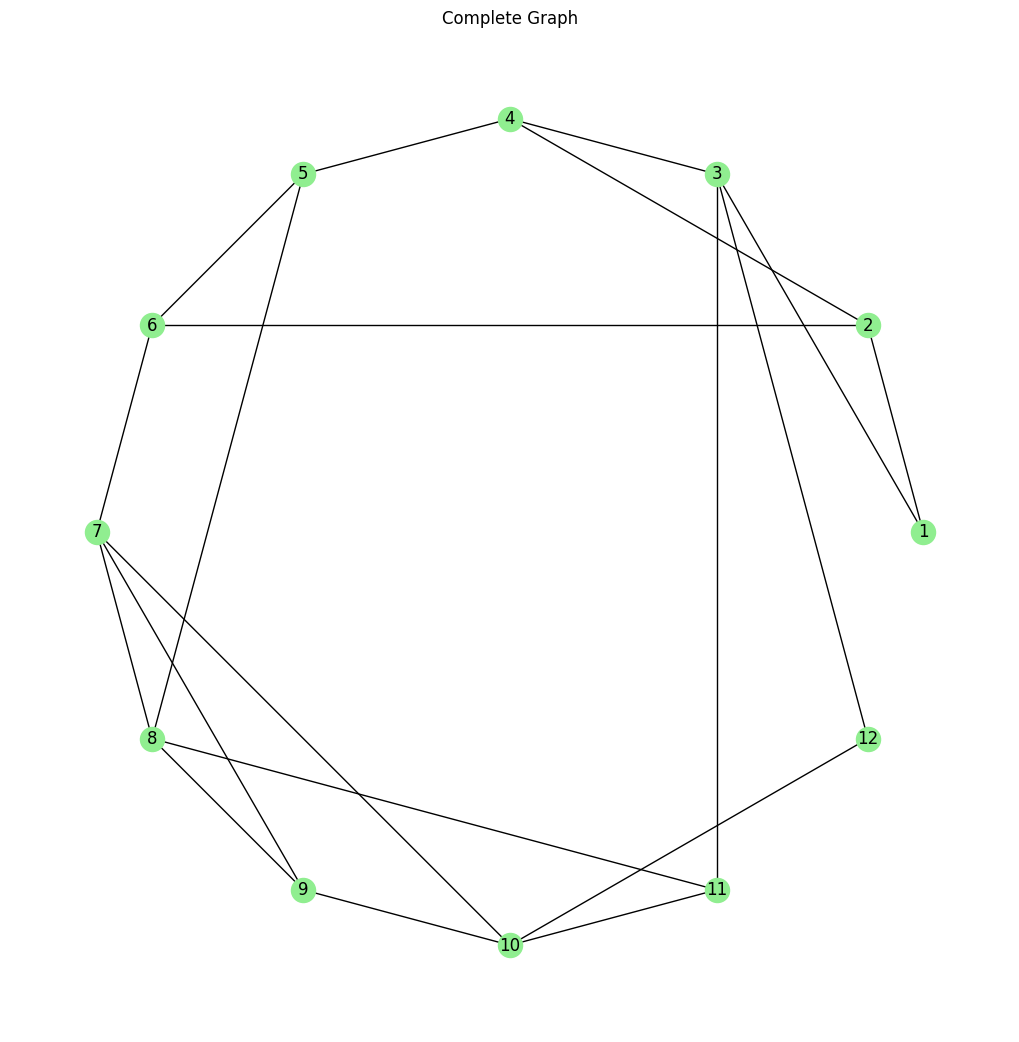

In [1]:
from topology import generate_complete_graph, draw_graph, topologie_finlande

G = topologie_finlande()
draw_graph(G)


# Slicing Generation

In [2]:
from generate_slices import generate_random_slices, vnf_profiles
import pandas as pd

# Generate the slices
slices = generate_random_slices(G, vnf_profiles, 6)

# Convert to readable table
slices_data = []
for i, (vnfs, vls) in enumerate(slices):
    slices_data.append({
        "Slice": i + 1,
        "VNF IDs": [v["id"] for v in vnfs],
        "VNF CPUs": [v["cpu"] for v in vnfs],
        "VL Pairs": [(vl["from"], vl["to"]) for vl in vls],
        "VL Bandwidths": [vl["bandwidth"] for vl in vls],
        "VL Latencies": [vl["latency"] for vl in vls]
    })

df_slices = pd.DataFrame(slices_data)
df_slices


,Slice,VNF IDs,VNF CPUs,VL Pairs,VL Bandwidths,VL Latencies
0,1,"[vnf0_0, vnf0_1, vnf0_2]","[3, 3, 3]","[(vnf0_0, vnf0_1), (vnf0_1, vnf0_2)]","[80, 80]","[300, 300]"
1,2,"[vnf1_0, vnf1_1, vnf1_2]","[3, 3, 3]","[(vnf1_0, vnf1_1), (vnf1_1, vnf1_2)]","[80, 80]","[300, 300]"
2,3,"[vnf2_0, vnf2_1, vnf2_2]","[1, 1, 1]","[(vnf2_0, vnf2_1), (vnf2_1, vnf2_2)]","[120, 120]","[300, 300]"
3,4,"[vnf3_0, vnf3_1, vnf3_2]","[2, 2, 2]","[(vnf3_0, vnf3_1), (vnf3_1, vnf3_2)]","[100, 100]","[300, 300]"
4,5,"[vnf4_0, vnf4_1, vnf4_2]","[1, 1, 1]","[(vnf4_0, vnf4_1), (vnf4_1, vnf4_2)]","[120, 120]","[300, 300]"
5,6,"[vnf5_0, vnf5_1, vnf5_2]","[2, 2, 2]","[(vnf5_0, vnf5_1), (vnf5_1, vnf5_2)]","[100, 100]","[300, 300]"


In [3]:
from run_abo_full_batch import run_abo_full_batch

node_capacity = {node: 10 for node in G.nodes}
link_latency = {(u, v): G[u][v]['latency'] for u, v in G.edges}
link_latency.update({(v, u): lat for (u, v), lat in link_latency.items()})
link_capacity = {(u, v): G[u][v]['bandwidth'] for u, v in G.edges}
link_capacity.update({(v, u): bw for (u, v), bw in link_capacity.items()})


df_results, abo_results = run_abo_full_batch(
    G,
    slices,
    node_capacity,            
    link_latency,             
    link_capacity             
)

print (df_results)
print (abo_results)

Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 2
→ Path: [1, 2], latency: 37ms, max allowed: 300ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 3
→ Path: [1, 3], latency: 183ms, max allowed: 300ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 4
→ Path: [1, 2, 4], latency: 124ms, max allowed: 300ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 5
→ Path: [1, 2, 4, 5], latency: 208ms, max allowed: 300ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 6
→ Path: [1, 2, 6], latency: 147ms, max allowed: 300ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 7
→ Path: [1, 2, 6, 7], latency: 280ms, max allowed: 300ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 8
→ Path: [1, 2, 4, 5, 8], latency: 252ms, max allowed: 300ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 9
→ Path: [1, 2, 4, 5, 8, 9], latency: 280ms, max allowed: 300ms
Attempting to route VL (vnf0_0, vnf0_1) from node 1 to 10
→ Path: [1, 3, 12, 10], latency: 290ms, 

In [24]:
import pandas as pd

def get_vnfs_per_node(result_list):
    # Coletamos todos os pares (node, vnf_id) de todos os resultados aceitos
    allocations = []
    for slice_idx, result in enumerate(result_list):
        if result is None:
            continue
        for vnf_id, node in result.placed_vnfs.items():
            allocations.append({"slice": slice_idx + 1, "node": node, "vnf": vnf_id})

    df = pd.DataFrame(allocations)
    return df.sort_values(by=["node", "slice", "vnf"]).reset_index(drop=True)

# Exemplo de uso com resultados do A*
vnfs_per_node = get_vnfs_per_node(abo_results)
vnfs_per_node


,slice,node,vnf
0,4,1,vnf3_2
1,6,1,vnf5_2
2,1,2,vnf0_1
3,2,2,vnf1_1
4,4,2,vnf3_0
5,6,2,vnf5_0
6,3,3,vnf2_0
7,4,3,vnf3_1
8,5,3,vnf4_0
9,6,3,vnf5_1


In [4]:
# Recreate the DataFrame from stored slices (reconstruct summary if needed)
abo_summary = []
for i, result in enumerate(abo_results):
    abo_summary.append({
        "slice": i + 1,
        "accepted": result is not None,
        "g_cost": result.g_cost if result else None
    })

# Compute metrics
accepted_costs = [entry["g_cost"] for entry in abo_summary if entry["accepted"]]
average_g_cost = sum(accepted_costs) / len(accepted_costs)
min_g_cost = min(accepted_costs)
max_g_cost = max(accepted_costs)

# Display metrics
{
    "Average g_cost (Mbps)": average_g_cost,
    "Min g_cost (Mbps)": min_g_cost,
    "Max g_cost (Mbps)": max_g_cost,
    "Total slices": len(abo_summary),
    "Accepted slices": len(accepted_costs),
    "Acceptance rate (%)": (len(accepted_costs) / len(abo_summary)) * 100
}


{'Average g_cost (Mbps)': 200.0,
 'Min g_cost (Mbps)': 160,
 'Max g_cost (Mbps)': 240,
 'Total slices': 6,
 'Accepted slices': 6,
 'Acceptance rate (%)': 100.0}

In [5]:
import pandas as pd
vnf_placement_data = []

for slice_index, result in enumerate(abo_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement.head()


,Slice,VNF,Node
0,1,vnf0_0,9
1,1,vnf0_1,2
2,1,vnf0_2,7
3,2,vnf1_0,9
4,2,vnf1_1,2


In [6]:
vl_routing_data = []

for slice_index, result in enumerate(abo_results):
    if result is not None:
        for (src, dst), path in result.routed_vls.items():
            vl_routing_data.append({
                "Slice": slice_index + 1,
                "VL": f"{src} → {dst}",
                "Path": " → ".join(str(n) for n in path)
            })

df_routing = pd.DataFrame(vl_routing_data)
df_routing.head()


,Slice,VL,Path
0,1,vnf0_0 → vnf0_1,9 → 8 → 5 → 4 → 2
1,1,vnf0_1 → vnf0_2,2 → 6 → 7
2,2,vnf1_0 → vnf1_1,9 → 8 → 5 → 4 → 2
3,2,vnf1_1 → vnf1_2,2 → 6 → 7
4,3,vnf2_0 → vnf2_1,3 → 11


# First-fit Orchestration 

In [7]:
from first_fit import run_first_fit

ff_df, ff_results, final_node_capacity = run_first_fit(G, slices, node_capacity)


In [8]:
ff_summary = []
for i, result in enumerate(ff_results):  
    ff_summary.append({
        "slice": i + 1,
        "accepted": result is not None,
        "g_cost": 0 if result else None 
    })

accepted_ff = [entry for entry in ff_summary if entry["accepted"]]

# Display metrics para First Fit
{
    "Average g_cost (Mbps)": None,
    "Min g_cost (Mbps)": None,
    "Max g_cost (Mbps)": None,
    "Total slices": len(ff_summary),
    "Accepted slices": len(accepted_ff),
    "Acceptance rate (%)": (len(accepted_ff) / len(ff_summary)) * 100
}


{'Average g_cost (Mbps)': None,
 'Min g_cost (Mbps)': None,
 'Max g_cost (Mbps)': None,
 'Total slices': 6,
 'Accepted slices': 6,
 'Acceptance rate (%)': 100.0}

In [9]:
for i, result in enumerate(ff_results):
    print(f"Slice {i+1}: {'Accepted' if result else 'Rejected'}")


Slice 1: Accepted
Slice 2: Accepted
Slice 3: Accepted
Slice 4: Accepted
Slice 5: Accepted
Slice 6: Accepted


In [10]:
final_node_capacity = node_capacity.copy()

for result in ff_results:
    if result:
        for vnf_id, node in result.placed_vnfs.items():
            cpu = next(
                vnf["cpu"]
                for vnf_chain, _ in slices
                for vnf in vnf_chain
                if vnf["id"] == vnf_id
            )
            final_node_capacity[node] -= cpu

print("Node capacity:")
for node, cap in final_node_capacity.items():
    print(f"Node {node}: {cap}")


Node capacity:
Node 1: 0
Node 2: 0
Node 3: 0
Node 4: 4
Node 5: 10
Node 6: 10
Node 7: 10
Node 8: 10
Node 9: 10
Node 10: 10
Node 11: 10
Node 12: 10


In [11]:
import pandas as pd

vnf_placement_data = []

for slice_index, result in enumerate(ff_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,1
1,1,vnf0_1,1
2,1,vnf0_2,1
3,2,vnf1_0,2
4,2,vnf1_1,2
5,2,vnf1_2,2
6,3,vnf2_0,1
7,3,vnf2_1,2
8,3,vnf2_2,3
9,4,vnf3_0,3


# A* 

In [12]:
from a_star import run_astar_full_batch



df_astar, astar_results = run_astar_full_batch(G, slices, node_capacity, link_latency, link_capacity)


print (df_astar)
print (astar_results)

→ Rejected placing vnf0_1 on node 1 due to slice duplication
Trying to route VL (vnf0_0, vnf0_1) from node 1 to 2
→ Path: [1, 2], latency: 37 ms (limit: 300 ms)
Trying to route VL (vnf0_0, vnf0_1) from node 1 to 3
→ Path: [1, 3], latency: 183 ms (limit: 300 ms)
Trying to route VL (vnf0_0, vnf0_1) from node 1 to 4
→ Path: [1, 2, 4], latency: 124 ms (limit: 300 ms)
Trying to route VL (vnf0_0, vnf0_1) from node 1 to 5
→ Path: [1, 2, 4, 5], latency: 208 ms (limit: 300 ms)
Trying to route VL (vnf0_0, vnf0_1) from node 1 to 6
→ Path: [1, 2, 6], latency: 147 ms (limit: 300 ms)
Trying to route VL (vnf0_0, vnf0_1) from node 1 to 7
→ Path: [1, 2, 6, 7], latency: 280 ms (limit: 300 ms)
Trying to route VL (vnf0_0, vnf0_1) from node 1 to 8
→ Path: [1, 2, 4, 5, 8], latency: 252 ms (limit: 300 ms)
Trying to route VL (vnf0_0, vnf0_1) from node 1 to 9
→ Path: [1, 2, 4, 5, 8, 9], latency: 280 ms (limit: 300 ms)
Trying to route VL (vnf0_0, vnf0_1) from node 1 to 10
→ Path: [1, 3, 12, 10], latency: 290 ms

In [13]:
astar_summary = []
for i, result in enumerate(astar_results):  
    astar_summary.append({
        "slice": i + 1,
        "accepted": result is not None,
        "g_cost": 0 if result else None 
    })

accepted_astar = [entry for entry in astar_summary if entry["accepted"]]

# Display metrics para First Fit
{
    "Average g_cost (Mbps)": None,
    "Min g_cost (Mbps)": None,
    "Max g_cost (Mbps)": None,
    "Total slices": len(astar_summary),
    "Accepted slices": len(accepted_astar),
    "Acceptance rate (%)": (len(accepted_astar) / len(astar_summary)) * 100
}


{'Average g_cost (Mbps)': None,
 'Min g_cost (Mbps)': None,
 'Max g_cost (Mbps)': None,
 'Total slices': 6,
 'Accepted slices': 6,
 'Acceptance rate (%)': 100.0}

In [14]:
final_node_capacity = node_capacity.copy()

for result in astar_results:
    if result:
        for vnf_id, node in result.placed_vnfs.items():
            cpu = next(
                vnf["cpu"]
                for vnf_chain, _ in slices
                for vnf in vnf_chain
                if vnf["id"] == vnf_id
            )
            final_node_capacity[node] -= cpu

print("Node capacity:")
for node, cap in final_node_capacity.items():
    print(f"Node {node}: {cap}")


Node capacity:
Node 1: -2
Node 2: 10
Node 3: 10
Node 4: 10
Node 5: -2
Node 6: 10
Node 7: 10
Node 8: 10
Node 9: 10
Node 10: 10
Node 11: 10
Node 12: -2


In [15]:
import pandas as pd

vnf_placement_data = []

for slice_index, result in enumerate(astar_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,1
1,1,vnf0_1,5
2,1,vnf0_2,12
3,2,vnf1_0,1
4,2,vnf1_1,5
5,2,vnf1_2,12
6,3,vnf2_0,1
7,3,vnf2_1,5
8,3,vnf2_2,12
9,4,vnf3_0,1


# FABO

In [16]:
from run_fabo_full_batch import run_fabo_full_batch
from tqdm import tqdm

fabo_df, fabo_results = run_fabo_full_batch(G, slices, node_capacity, link_latency, link_capacity)

print (fabo_df)
print (fabo_results)


Running FABO: 100%|██████████| 6/6 [00:00<00:00, 249.68slice/s]

   slice  accepted  g_cost
0      1      True   160.0
1      2      True   160.0
2      3      True   240.0
3      4      True   200.0
4      5      True   240.0
5      6      True   200.0
[<run_fabo_full_batch.FABOState object at 0x7f759cc16480>, <run_fabo_full_batch.FABOState object at 0x7f759cc144a0>, <run_fabo_full_batch.FABOState object at 0x7f759cc14c50>, <run_fabo_full_batch.FABOState object at 0x7f759cc14560>, <run_fabo_full_batch.FABOState object at 0x7f759cc16d80>, <run_fabo_full_batch.FABOState object at 0x7f759cc17170>]


In [17]:
import pandas as pd

vnf_placement_data = []

for slice_index, result in enumerate(fabo_results):
    if result is not None:
        for vnf_id, node in result.placed_vnfs.items():
            vnf_placement_data.append({
                "Slice": slice_index + 1,
                "VNF": vnf_id,
                "Node": node
            })

df_placement = pd.DataFrame(vnf_placement_data)
df_placement = df_placement.sort_values(by=["Slice", "VNF"])
df_placement


,Slice,VNF,Node
0,1,vnf0_0,1
1,1,vnf0_1,3
2,1,vnf0_2,4
3,2,vnf1_0,1
4,2,vnf1_1,3
5,2,vnf1_2,4
6,3,vnf2_0,1
7,3,vnf2_1,3
8,3,vnf2_2,4
9,4,vnf3_0,1


In [18]:
final_node_capacity = node_capacity.copy()

for result in fabo_results:
    if result:
        for vnf_id, node in result.placed_vnfs.items():
            cpu = next(
                vnf["cpu"]
                for vnf_chain, _ in slices
                for vnf in vnf_chain
                if vnf["id"] == vnf_id
            )
            final_node_capacity[node] -= cpu

print("Node capacity:")
for node, cap in final_node_capacity.items():
    print(f"Node {node}: {cap}")


Node capacity:
Node 1: -2
Node 2: 10
Node 3: -2
Node 4: -2
Node 5: 10
Node 6: 10
Node 7: 10
Node 8: 10
Node 9: 10
Node 10: 10
Node 11: 10
Node 12: 10


# Comparasion

In [19]:
from compute_energy import compute_energy_per_slice


energy_abo_per_slice, cpu_abo_all = compute_energy_per_slice(abo_results, slices, node_capacity)
energy_ff_per_slice, cpu_ff_all = compute_energy_per_slice(ff_results, slices, node_capacity)
energy_astar_per_slice, cpu_astar_all = compute_energy_per_slice(astar_results, slices, node_capacity)
energy_fabo_per_slice, cpu_fabo_all = compute_energy_per_slice(fabo_results, slices, node_capacity)



In [20]:
comparison = df_results.copy()
comparison["energy_abo"] = energy_abo_per_slice
comparison["energy_ff"] = energy_ff_per_slice
comparison["energy_astar"] = energy_astar_per_slice
comparison["energy_fabo"] = energy_fabo_per_slice


totals_row = {
    "slice": "Total",
    "energy_abo": comparison["energy_abo"].sum(),
    "energy_ff": comparison["energy_ff"].sum(),
    "energy_astar": comparison["energy_astar"].sum(),
    "energy_fabo": comparison["energy_fabo"].sum()
}

comparison_with_total = pd.concat([comparison, pd.DataFrame([totals_row])], ignore_index=True)
comparison_with_total


comparison_with_total


,slice,accepted,g_cost,energy_abo,energy_ff,energy_astar,energy_fabo
0,1,True,160.0,33,23,33,33
1,2,True,160.0,33,23,33,33
2,3,True,240.0,21,21,21,21
3,4,True,200.0,27,17,27,27
4,5,True,240.0,21,11,21,21
5,6,True,200.0,27,17,27,27
6,Total,NaN,NaN,162,112,162,162


<Axes: title={'center': 'CPU Usage per Node by Algorithm'}, xlabel='Node'>

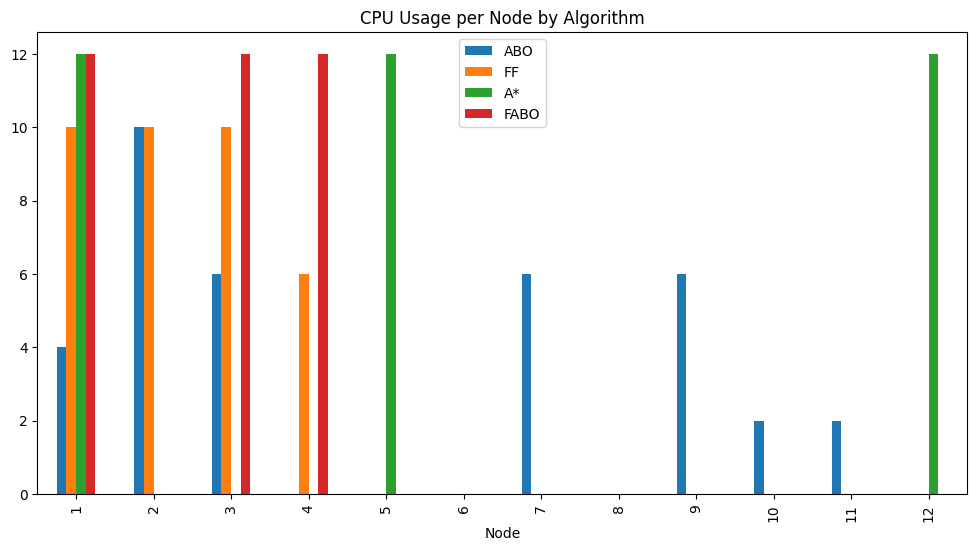

In [21]:
from compute_energy import compute_energy_per_slice
import pandas as pd

def get_cpu_distribution(results, slices, node_capacity):
    cpu_usage_total = {n: 0 for n in node_capacity}
    _ , cpu_usage_slice = compute_energy_per_slice(results, slices, node_capacity)
    for slice_cpu in cpu_usage_slice:
        for n, cpu in slice_cpu.items():
            cpu_usage_total[n] += cpu
    return cpu_usage_total


cpu_abo_all = get_cpu_distribution(abo_results, slices, node_capacity)
cpu_ff_all = get_cpu_distribution(ff_results, slices, node_capacity)
cpu_astar_all = get_cpu_distribution(astar_results, slices, node_capacity)
cpu_fabo_all = get_cpu_distribution(fabo_results, slices, node_capacity)

# Montagem do DataFrame
df_cpu = pd.DataFrame({
    "Node": list(cpu_abo_all.keys()),
    "ABO": list(cpu_abo_all.values()),
    "FF": list(cpu_ff_all.values()),
    "A*": list(cpu_astar_all.values()),
    "FABO": list(cpu_fabo_all.values()),
}).set_index("Node")

df_cpu

df_cpu.plot(kind='bar', figsize=(12, 6), title="CPU Usage per Node by Algorithm")



,ABO,FF,A*,FABO
Node,,,,
1,2,4,6,6
2,4,4,0,0
3,4,7,0,6
4,0,3,0,6
5,0,0,6,0
7,2,0,0,0
9,2,0,0,0
10,2,0,0,0
11,2,0,0,0


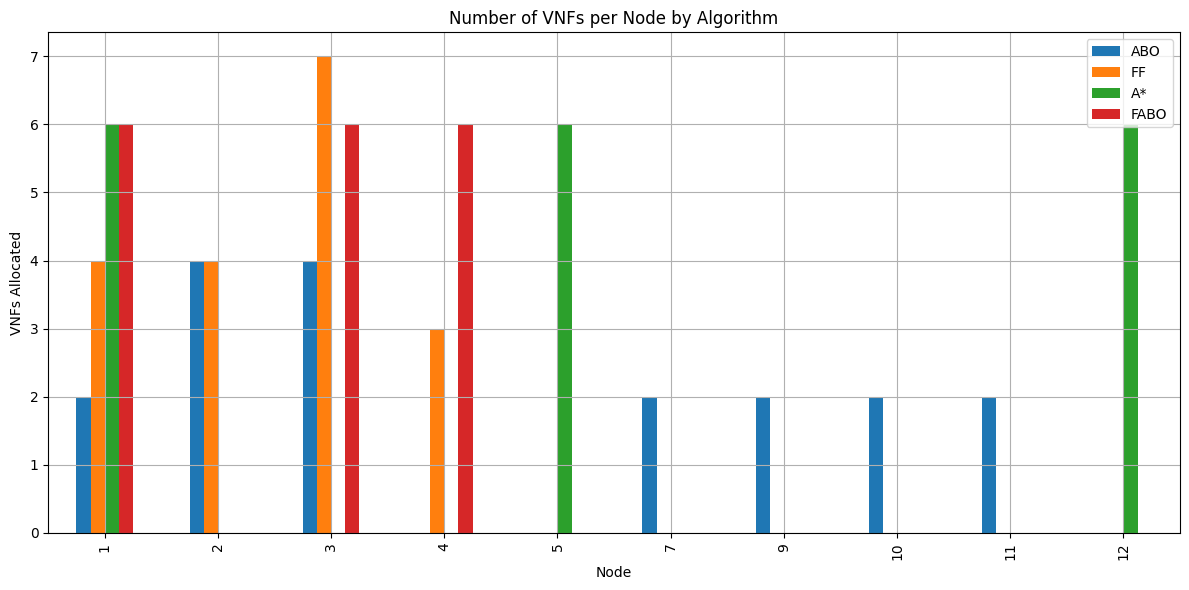

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def count_vnfs_per_node(results):
    node_counter = Counter()
    for result in results:
        if result is None:
            continue
        node_counter.update(result.placed_vnfs.values())
    return node_counter

# Contagem de VNFs por nó para cada algoritmo
vnfs_abo = count_vnfs_per_node(abo_results)
vnfs_ff = count_vnfs_per_node(ff_results)
vnfs_astar = count_vnfs_per_node(astar_results)
vnfs_fabo = count_vnfs_per_node(fabo_results)

# Todos os nós (garante inclusão dos que ficaram com zero)
all_nodes = sorted(set(vnfs_abo) | set(vnfs_ff) | set(vnfs_astar) | set(vnfs_fabo))

# Construção do DataFrame
df_vnfs = pd.DataFrame({
    "Node": all_nodes,
    "ABO": [vnfs_abo.get(n, 0) for n in all_nodes],
    "FF": [vnfs_ff.get(n, 0) for n in all_nodes],
    "A*": [vnfs_astar.get(n, 0) for n in all_nodes],
    "FABO": [vnfs_fabo.get(n, 0) for n in all_nodes],
}).set_index("Node")

# Exibição do DataFrame (opcional)
display(df_vnfs)

# Gráfico
df_vnfs.plot(kind="bar", figsize=(12, 6), title="Number of VNFs per Node by Algorithm")
plt.ylabel("VNFs Allocated")
plt.xlabel("Node")
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
from compute_energy import compute_total_latency
from compute_energy import compute_total_bandwidth

latency_abo = compute_total_latency(abo_results, link_latency)
#latency_ff = compute_total_latency(ff_results, link_latency)
latency_astar = compute_total_latency(astar_results, link_latency)
latency_fabo = compute_total_latency(fabo_results, link_latency)

bandwidth_abo = compute_total_bandwidth(abo_results, slices)
#bandwidth_ff = compute_total_bandwidth(ff_results, slices)
bandwidth_astar = compute_total_bandwidth(astar_results, slices)
bandwidth_fabo = compute_total_bandwidth(fabo_results, slices)

comparison["latency_abo"] = latency_abo
#comparison["latency_ff"] = latency_ff
comparison["latency_astar"] = latency_astar
comparison["latency_fabo"] = latency_fabo

comparison["bandwidth_abo"] = bandwidth_abo
#comparison["bandwidth_ff"] = bandwidth_ff
comparison["bandwidth_astar"] = bandwidth_astar
comparison["bandwidth_fabo"] = bandwidth_fabo


totals_row.update({
    "latency_abo": comparison["latency_abo"].sum(),
    #"latency_ff": comparison["latency_ff"].sum(),
    "latency_astar": comparison["latency_astar"].sum(),
    "latency_fabo": comparison["latency_fabo"].sum(),
    "bandwidth_abo": comparison["bandwidth_abo"].sum(),
    #"bandwidth_ff": comparison["bandwidth_ff"].sum(),
    "bandwidth_astar": comparison["bandwidth_astar"].sum(),
    "bandwidth_fabo": comparison["bandwidth_fabo"].sum(),
})

comparison_with_total = pd.concat([comparison, pd.DataFrame([totals_row])], ignore_index=True)


comparison_with_total


,slice,accepted,g_cost,energy_abo,energy_ff,energy_astar,energy_fabo,latency_abo,latency_astar,latency_fabo,bandwidth_abo,bandwidth_astar,bandwidth_fabo
0,1,True,160.0,33,23,33,33,486,348,245,160,160,160
1,2,True,160.0,33,23,33,33,486,348,245,160,160,160
2,3,True,240.0,21,21,21,21,123,348,245,240,240,240
3,4,True,200.0,27,17,27,27,332,348,245,200,200,200
4,5,True,240.0,21,11,21,21,123,348,245,240,240,240
5,6,True,200.0,27,17,27,27,332,348,245,200,200,200
6,Total,NaN,NaN,162,112,162,162,1882,2088,1470,1200,1200,1200


In [27]:
slice_stats = []

for i, (vnf_chain, vl_chain) in enumerate(slices):
    num_vnfs = len(vnf_chain)
    num_vls = len(vl_chain)
    total_cpu = sum(v["cpu"] for v in vnf_chain)
    avg_cpu = total_cpu / num_vnfs if num_vnfs else 0
    total_bw = sum(vl["bandwidth"] for vl in vl_chain)
    avg_bw = total_bw / num_vls if num_vls else 0
    max_latency = max((vl["latency"] for vl in vl_chain), default=0)

    slice_stats.append({
        "Slice": i + 1,
        "Num_VNFs": num_vnfs,
        "Num_VLs": num_vls,
        "Total_CPU": total_cpu,
        "Avg_CPU": round(avg_cpu, 2),
        "Total_BW": total_bw,
        "Avg_BW": round(avg_bw, 2),
        "Max_Latency_Constraint": max_latency,
    })

import pandas as pd
df_slice_stats = pd.DataFrame(slice_stats)
df_slice_stats


,Slice,Num_VNFs,Num_VLs,Total_CPU,Avg_CPU,Total_BW,Avg_BW,Max_Latency_Constraint
0,1,3,2,9,3.0,160,80.0,300
1,2,3,2,9,3.0,160,80.0,300
2,3,3,2,3,1.0,240,120.0,300
3,4,3,2,6,2.0,200,100.0,300
4,5,3,2,3,1.0,240,120.0,300
5,6,3,2,6,2.0,200,100.0,300
